In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path

import pytorch_lightning as pl
import yaml
from torch.utils.data import DataLoader
from transformers import set_seed

from datasets.class_writer import CSVWriter
from datasets.class_dataset import CSVDataset
from models._old_deroberta_model import PretrainedDeRoBertaClass as OldPretrainedDeRoBertaClass
from models.deroberta_model import PretrainedDeRoBertaClass
from utils.metrics import Statistics
from utils.log_reader import TensorBoardReader

set_seed(42)

In [3]:
# Config initialisation
data_config = yaml.load(open("configs/multi_data_config.yaml", 'r'), Loader=yaml.Loader)
deberta_model_config = yaml.load(open("configs/deberta_model_config.yaml", 'r'), Loader=yaml.Loader)

In [4]:
# Data processing
val_dataset = CSVDataset(data_config["validate_data_path"],
                         is_uncased=data_config["is_uncased"],
                         pretrained_tokenizer=data_config["pretrained_tokenizer_path"],
                         max_length=data_config["max_token_number"])
val_dataloader = DataLoader(val_dataset, shuffle=False,
                            batch_size=data_config["batch_size"], drop_last=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Этап 1
Сначала было рассмотрено самое популярное решение среди участников: fine-tuning модели DeBERTa для классификации текстов.
В качестве pooling-а выхода модели было использовано взятие скрытого состояния первого токена.
Результат проецировался с помощью ReLU и линейного слоя.

Для обучения использовался оптимизатор AdamW вместе с OneCycle планировщиком, линейно изменяющий learning rate.
Первые 10% шагов происходит стадия разогрева с увеличением learning rate для лучшего сохранения предзагруженных весов.
Оставшееся время learning rate постепенно уменьшается для более точных шагов.

In [5]:
# Getting path to the last checkpoint
t_reader = TensorBoardReader(Path(deberta_model_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = t_reader.get_ckpt_path(1)

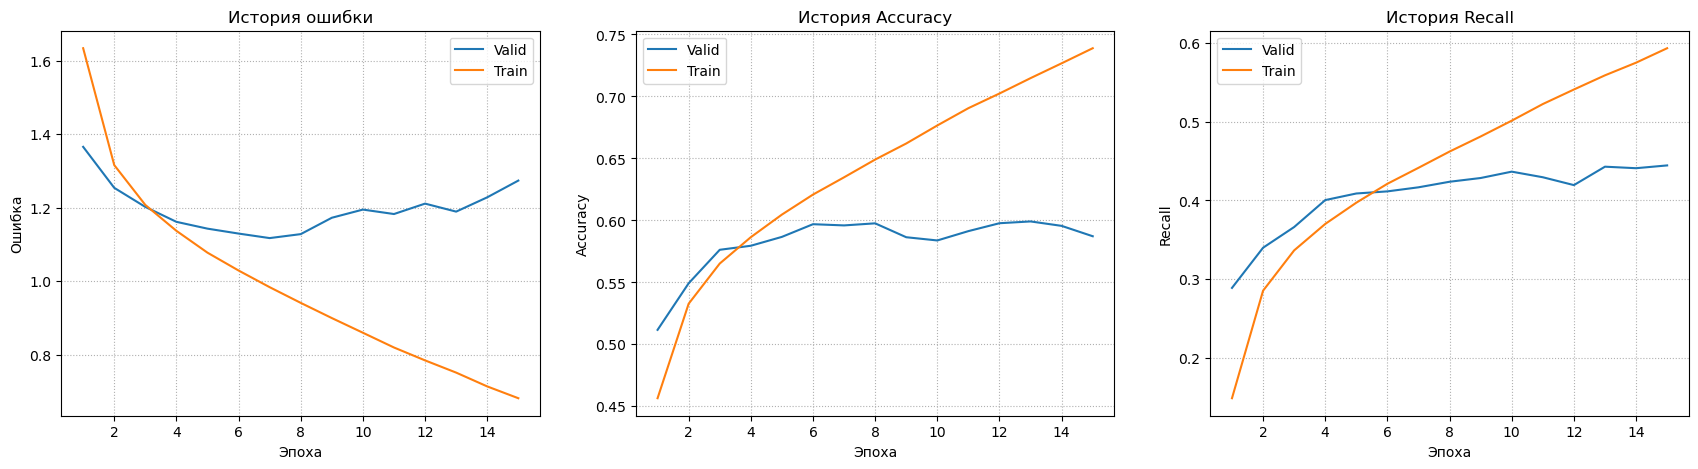

In [6]:
# Training visualisation
t_reader.plot_tensorboard_graphics(1)

In [7]:
# Pytorch lightning
deberta_model = OldPretrainedDeRoBertaClass.load_from_checkpoint(path_to_checkpoint)
print(deberta_model)
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(deberta_model, val_dataloader)

Some weights of the model checkpoint at microsoft/mdeberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'deberta.embeddings.word_embeddings._weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSeque

PretrainedDeRoBertaClass(
  (model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(250102, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dropo

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_acc', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5990513563156128
       test_recall          0.4427665174007416
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.5990513563156128, 'test_recall': 0.4427665174007416}]

                     precision    recall  f1-score   support

              Human       0.83      0.84      0.83      8521
             M-BART       0.53      0.65      0.58       417
           M-BART50       0.51      0.45      0.48      1986
            M2M-100       0.29      0.42      0.34      1803
            OPUS-MT       0.37      0.37      0.37      2014
          mT5-Large       0.39      0.25      0.30       810
          mT5-Small       0.53      0.42      0.47       490
       ruGPT2-Large       0.65      0.58      0.62       395
       ruGPT3-Large       0.52      0.50      0.51      1644
      ruGPT3-Medium       0.49      0.41      0.44      1170
       ruGPT3-Small       0.54      0.65      0.59      1154
          ruT5-Base       0.64      0.69      0.67       440
ruT5-Base-Multitask       0.37      0.14      0.20       370
         ruT5-Large       0.28      0.10      0.15       290

           accuracy                           0.60     21504
          macro avg   

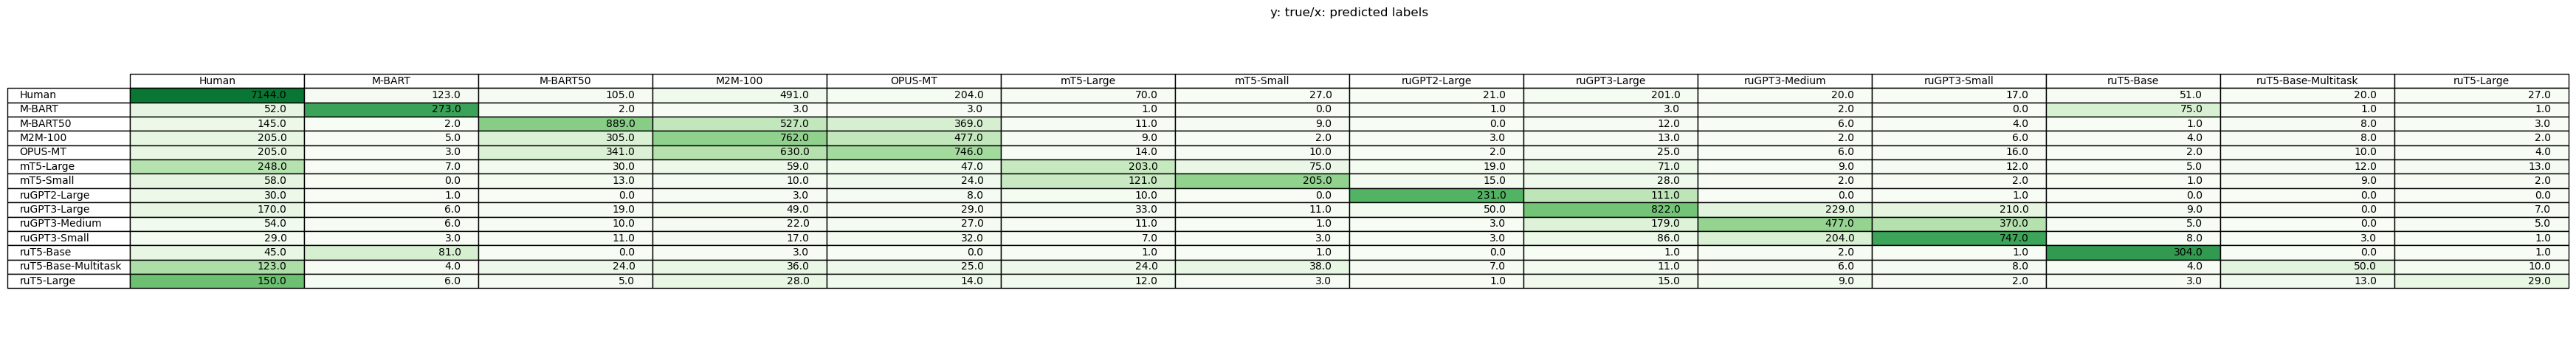

Wrongly predicted examples:
| Record id: | Sentence:                                                                                                                                                                                                                                                                                                                                                                                                                                                           | True label:  | Pred labels:  |
| 104959     | Он не хотел пугать ее да мужичков.                                                                                                                                                                                                                                                                                                                                                                                                                                  | Hum

In [8]:
# Print metrics
stats = Statistics(deberta_model, val_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

### Этап 2
Чтобы исключить возможность потери информации из DeBERTa в следующем эксперименте был использован AveragePooling для агрегации скрытых состояний всех токенов в один вектор.

In [9]:
# Getting path to the last checkpoint
t_reader = TensorBoardReader(Path(deberta_model_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = t_reader.get_ckpt_path(2)

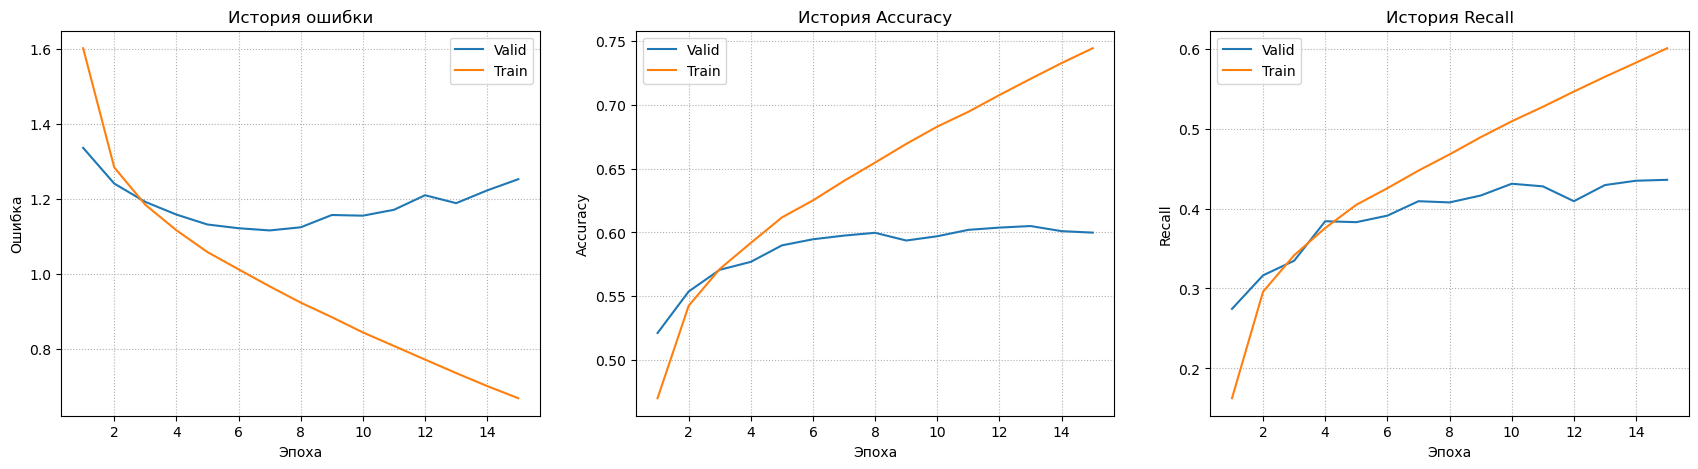

In [10]:
# Training visualisation
t_reader.plot_tensorboard_graphics(2)

In [11]:
# Pytorch lightning
deberta_model = OldPretrainedDeRoBertaClass.load_from_checkpoint(path_to_checkpoint)
print(deberta_model)
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(deberta_model, val_dataloader)

Some weights of the model checkpoint at microsoft/mdeberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'deberta.embeddings.word_embeddings._weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSeque

PretrainedDeRoBertaClass(
  (model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(250102, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dropo

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_acc', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.604864239692688
       test_recall          0.42935889959335327
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.604864239692688, 'test_recall': 0.42935889959335327}]

                     precision    recall  f1-score   support

              Human       0.80      0.87      0.83      8521
             M-BART       0.57      0.65      0.61       417
           M-BART50       0.51      0.43      0.47      1986
            M2M-100       0.30      0.25      0.28      1803
            OPUS-MT       0.35      0.51      0.41      2014
          mT5-Large       0.43      0.21      0.28       810
          mT5-Small       0.61      0.37      0.46       490
       ruGPT2-Large       0.65      0.54      0.59       395
       ruGPT3-Large       0.51      0.54      0.53      1644
      ruGPT3-Medium       0.50      0.41      0.45      1170
       ruGPT3-Small       0.56      0.59      0.58      1154
          ruT5-Base       0.75      0.57      0.65       440
ruT5-Base-Multitask       0.41      0.19      0.26       370
         ruT5-Large       0.18      0.09      0.12       290

           accuracy                           0.60     21504
          macro avg   

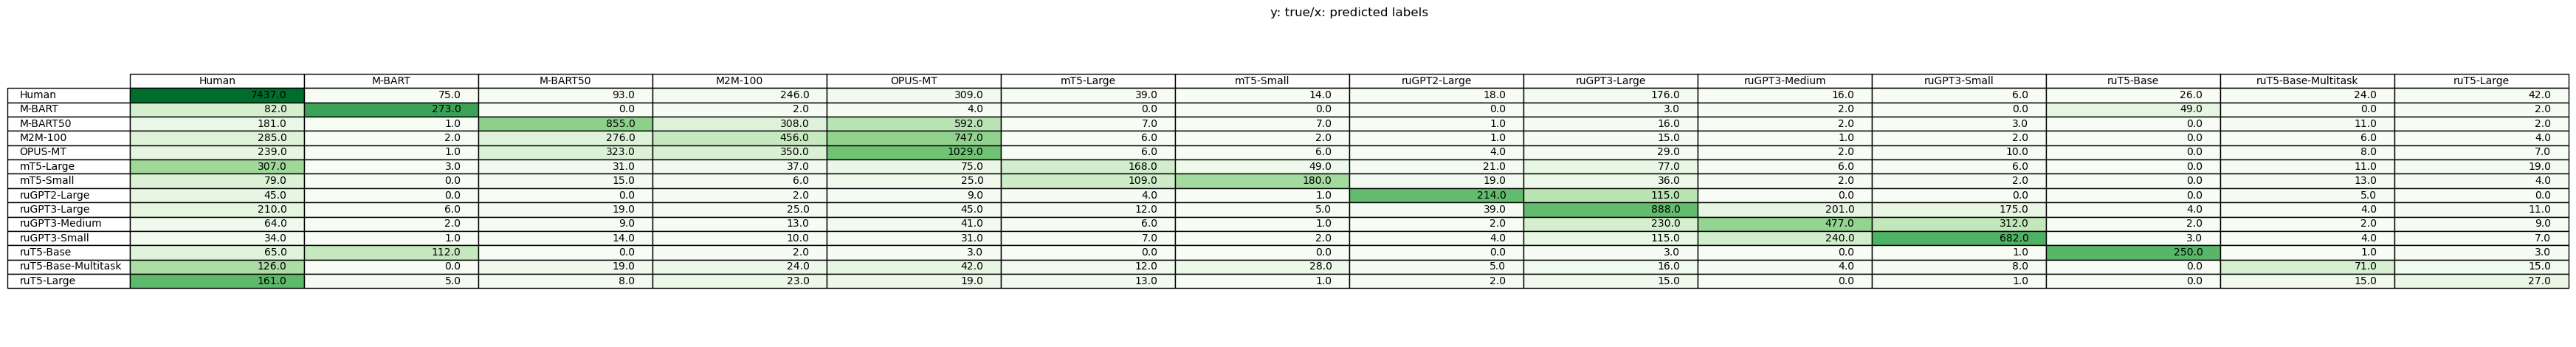

Wrongly predicted examples:
| Record id: | Sentence:                                                                                                                                                                                                                                                                                                                                | True label:         | Pred labels:  |
| 120930     | ефимовцы с "андроньевскими", "васильевскими", "котельниковскими" с "котельниковскими" словами.                                                                                                                                                                                                                                           | ruT5-Base-Multitask | ruGPT3-Small  |
| 190004     | Но в этом году воду у нас отключили одновременно, и мы не знали, что делать.                                                                                                                 

In [12]:
# Print metrics
stats = Statistics(deberta_model, val_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

### Последний этап
Разметим тестовый набор данных лучшей моделью для участия в соревновании

In [13]:
# Processing test data
test_dataset = CSVDataset(data_config["test_data_path"],
                          is_uncased=data_config["is_uncased"],
                          without_labels=True,
                          pretrained_tokenizer=data_config["pretrained_tokenizer_path"],
                          max_length=data_config["max_token_number"])
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=data_config["batch_size"], drop_last=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
# Markup of test data
deberta_writer = CSVWriter(deberta_model, test_dataloader, val_dataloader.dataset.index2label)
deberta_writer.write(data_config["pred_data_path"])